In [1]:
import os
import numpy as np
import pickle

In [2]:

def parse_raw(_file_name):#for 360 ds log
  temp = open(_file_name).read().split('\n')[:-1]
  temp2 = [map(float, item.split(' ')) for item in temp]
  for i, _ in enumerate(temp2):
    item = temp2[i]
    temp2[i] = [item[0], item[1], item[3], item[5], item[4], item[2]]
  return np.array(temp2)

def parse_raw2(_file_name):#for 360 ds log
    temp = open(_file_name).read().split('\n')[1:-1]#remove header and useless last line
    temp2 = [map(float, item.split(',')[1:]) for item in temp]
    #timestamp_list = [datetime.datetime.strptime(item.split(',')[0], "%Y-%m-%d %H:%M:%S.%f") for item in temp]
    for i, _ in enumerate(temp2):
        item = temp2[i]#timestamp, z, y, x, w, ....
        temp2[i] = [item[0], -1, item[3], item[2], item[1], item[4]]
    return np.array(temp2)

def get_series_ds2(_file_path, _topic, _dataset=0):
    file_name_list = []
    series_ds = []
    f_parse=None
    file_sig=''
    if _dataset==0:
        f_parse=parse_raw
        file_sig='.txt'
    elif _dataset==1:
        f_parse=parse_raw2
        file_sig='.csv'
    
    for root, dirs, files in os.walk(_file_path):
        for file in files:
            if file.endswith(file_sig) and file.lower().find(_topic) >= 0:
                 file_name_list.append((os.path.join(root, file)))

    for idx, file_name in enumerate(file_name_list):
        series = f_parse(file_name);
        series_ds.append(series.tolist())
    series_ds = np.array(series_ds)
    return series_ds

def extract_direction(_q, v0=[1, 0, 0]):
    return _q.rotate(v0)

def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))/np.pi * 180
    #return math.acos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))/np.pi * 180



def cutoff_vel_acc(_vector_ds):
    dd = 7
    stats_ds = []
    for vec in _vector_ds:
        stats = []
        for idx in range(len(vec)):
            if idx < 5:
                continue
            dt = vec[idx][0] - vec[idx-dd][0]
            theta = angle_between(vec[idx][1], vec[idx-dd][1])
            v = theta * 1.0 / dt   
            vec[idx][2] = v
            
            #if idx == 1:
            #   continue
            dv = vec[idx][2] - vec[idx-dd][2]
            a = dv * 1.0 / dt
            vec[idx][3] = a
            item = [vec[idx][0], vec[idx][1], v, a]
            stats.append(item)
        stats_ds.append(stats)
    result = []
    for vector in stats_ds:
        #removing too fast movement
        remove_idx = set()
        collect_mode = 0 #0 is normal, 1 is begin fast, 2 is begin slow
        #print stats_ds[0]
        for idx, (timestamp, vec, v, a) in enumerate(vector):
            if v > 20 and a > 50:
                collect_mode = 1;
            if a < -40 and collect_mode == 1:#slowing down
                collect_mode = 2
            if collect_mode == 2 and a > -50  and v < 20:#slowing down finish
                collect_mode = 0
            if collect_mode == 1 or collect_mode == 2:
                remove_idx.add(idx)
        result.append([vector[idx] for idx,_ in enumerate(vector) if idx not in remove_idx])
    return result

def get_vector_ds(_topic, _dataset=0, cutoff=True):
    from pyquaternion import Quaternion
    
    if _dataset==0:
        file_path = u'/home/u9168/salnet/Datasets/Dataset1/results/'
    elif _dataset==1:
        file_path = u'/home/u9168/salnet/Datasets/Dataset2/Formated_Data/Experiment_1/'
        
    series_ds = get_series_ds2(file_path, _topic, _dataset=_dataset)
    vector_ds = []
    for series in series_ds:
        vec = []
        #for item in series:
        for idx in np.arange(0, len(series)):
            item = series[idx]
            if _dataset==0:
                v = extract_direction(Quaternion([item[5], item[4], item[3], item[2]]))#
            elif _dataset==1:
                v = extract_direction(Quaternion([item[5], -item[4], item[3], -item[2]]), v0=[0, 0, 1])#
            vec.append([item[0], v, 0, 0])#time, cur pos, angular vec, angular acc
        vector_ds.append(vec)
    
    if cutoff==True:
        result = cutoff_vel_acc(vector_ds)
    else:
        result = vector_ds
    return result

In [3]:
#vector_ds = get_vector_ds('paris')
vector_ds2 = get_vector_ds('1', _dataset=1)

/glob/intel-python/versions/2018u1/intelpython2/lib/python2.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in double_scalars
/glob/intel-python/versions/2018u1/intelpython2/lib/python2.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in double_scalars
/glob/intel-python/versions/2018u1/intelpython2/lib/python2.7/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in double_scalars


In [76]:
import saldat_head_orientation
reload(saldat_head_orientation)

<module 'saldat_head_orientation' from 'saldat_head_orientation.pyc'>

In [77]:
dirpath1 = u'/home/u9168/salnet/Datasets/Dataset1/results/'
dirpath2 = u'/home/u9168/salnet/Datasets/Dataset2/Formated_Data/Experiment_1/'
ext1 = '.txt'
ext2 = '.csv'
headoren = saldat_head_orientation.HeadOrientation(dirpath1, dirpath2, ext1, ext2)

In [42]:
dataset = headoren._DATASET2
dirpath, filename_list, f_parse, f_extract_direction = headoren.load_filename_list(dataset, '3')
series_ds = headoren.load_series_ds(filename_list, f_parse)
vector_ds = headoren.headpos_to_headvec(series_ds, f_extract_direction)
vector_ds = headoren.cutoff_vel_acc(vector_ds)

In [70]:
fixation_list = headoren.get_fixation(vector_ds, 37.23)

In [87]:
import saldat_saliency
reload(saldat_saliency)

<module 'saldat_saliency' from 'saldat_saliency.py'>

In [88]:
var = 20
dataset=saldat_saliency.Fixation._DATASET2
salsal = saldat_saliency.Fixation(var)

In [49]:
heat_map0 = salsal.create_saliency(fixation_list, verbal=False)

In [75]:
import head_orientation_lib
reload(head_orientation_lib)

<module 'head_orientation_lib' from 'head_orientation_lib.pyc'>

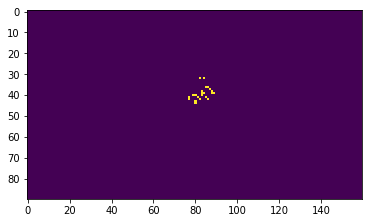

In [89]:
#pixel_set0, fix_list0 = create_fixation_pixelset(fixation_list)
#pixel_set, idx_list = filter_fixation(fix_list0)
#fmap0 = create_fixation_map(pixel_set)

fmap0 = headoren.create_fixation_map(fixation_list)
plt.imshow(fmap0)

#fixation maps is correct

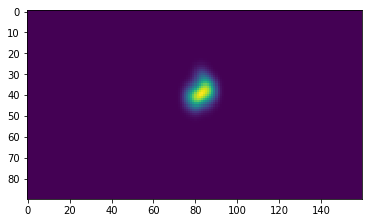

In [90]:
heat_map0 = salsal.create_saliency(fixation_list, verbal=False)

plt.imshow(heat_map0)#rhinos-13.23

In [ ]:
len(fixation_list)

In [91]:
#backup



In [21]:


from Quaternion import Quat
from pyquaternion import Quaternion

from matplotlib import pyplot as plt
%matplotlib inline

def create_fixation_map(fixation_pixelset):
    result = np.zeros(shape=(head_orientation_lib.H, head_orientation_lib.W), dtype=np.int)
    for x, y in fixation_pixelset:
        result[x, y] = 1
    return result

def create_fixation_pixellist(fixation_list):
    pixel_list = []
    for time, v, _, _ in fixation_list:
        theta, phi = head_orientation_lib.vector_to_ang(v)
        x, y = head_orientation_lib.ang_to_geoxy(theta, phi, head_orientation_lib.H, head_orientation_lib.W)
        pixel_list.append((x, y))
    return pixel_list

def create_fixation_pixelset(fixation_list):
    pixel_set = set()
    orifix_list = []
    for time, v, _, _ in fixation_list:
        theta, phi = head_orientation_lib.vector_to_ang(v)
        x, y = head_orientation_lib.ang_to_geoxy(theta, phi, head_orientation_lib.H, head_orientation_lib.W)
        if (x, y) not in pixel_set:
            pixel_set.add((x, y))
            orifix_list.append([time, v, 0, 0])
    return pixel_set, orifix_list

def filter_fixation(_fix_list):
    result = set()
    _geoxy_set = create_fixation_pixellist(_fix_list)
    
    X = [[xy[0], xy[1]] for xy in _geoxy_set]
    #labels_true += [0 for xy in geoxy_false_set]
    std = StandardScaler()
    X = std.fit_transform(X)
    db = DBSCAN(eps=0.3, min_samples=5)
    db.fit_predict(X)
    temp = std.inverse_transform(X[db.core_sample_indices_])
    
    return set([(int(item[0]), int(item[1])) for item in temp]), db.core_sample_indices_

def filter_fixation_old(_geoxy_set):
    result = set()
    
    X = [[xy[0], xy[1]] for xy in _geoxy_set]
    #labels_true += [0 for xy in geoxy_false_set]
    std = StandardScaler()
    X = std.fit_transform(X)
    db = DBSCAN(eps=0.3, min_samples=5)
    db.fit_predict(X)
    temp = std.inverse_transform(X[db.core_sample_indices_])
    return set([(int(item[0]), int(item[1])) for item in temp]), db.core_sample_indices_

def pixel_to_vec(hi, wi):
    phi, theta = head_orientation_lib.pixel_to_ang(hi, wi, head_orientation_lib.H, head_orientation_lib.W)
    t = Quat([0.0, theta, phi]).q #nolonger use Quat
    q = Quaternion([t[3], t[2], -t[1], t[0]])
    v = head_orientation_lib.extract_direction_dataset1(q)
    return v